# Model Training - Genre Classification CNN

This notebook trains the CNN model for music genre classification using the preprocessed mel spectrograms.

**Key Steps:**
1. Load preprocessed data
2. Initialize PyTorch CNN model
3. Train with early stopping and learning rate scheduling
4. Evaluate on test set
5. Visualize training history
6. Save model and metrics

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import torch

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

from models.cnn import GenreClassifierCNN
from models.trainer import GenreClassifierTrainer, load_processed_data

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Ti


## 2. Load Preprocessed Data

In [2]:
data_path = Path.cwd().parent / 'data' / 'processed'

X_train, y_train, X_val, y_val, X_test, y_test, metadata = load_processed_data(data_path)

print("\nDataset shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

print("\nGenre mapping:")
for genre, idx in sorted(metadata['genre_to_id'].items(), key=lambda x: x[1]):
    print(f"  {idx}: {genre}")

Loaded data from c:\Programming\xai-music-genre-robustness\data\processed
  Train: (6983, 128, 130, 1), Labels: (6983,)
  Val: (1498, 128, 130, 1), Labels: (1498,)
  Test: (1500, 128, 130, 1), Labels: (1500,)

Dataset shapes:
  X_train: (6983, 128, 130, 1), y_train: (6983,)
  X_val: (1498, 128, 130, 1), y_val: (1498,)
  X_test: (1500, 128, 130, 1), y_test: (1500,)

Genre mapping:
  0: blues
  1: classical
  2: country
  3: disco
  4: hiphop
  5: jazz
  6: metal
  7: pop
  8: reggae
  9: rock


## 3. Initialize Model

We use a 4-block CNN architecture:
- **Block 1-4**: Conv layers with BatchNorm, ReLU, MaxPooling, Dropout
- **Features**: 32 → 64 → 128 → 256 filters
- **Classifier**: Global Average Pooling + 2 FC layers
- **Grad-CAM Ready**: Stores intermediate activations for explainability

In [3]:
# Initialize model
num_classes = len(metadata['genre_to_id'])
model = GenreClassifierCNN(num_classes=num_classes)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {model.__class__.__name__}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:")
print(model)

Model: GenreClassifierCNN
Total parameters: 1,440,618
Trainable parameters: 1,440,618

Model architecture:
GenreClassifierCNN(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.15, inplace=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

## 4. Train Model

Training configuration:
- **Optimizer**: Adam with learning rate 0.0005 and L2 weight decay 1e-4
- **Loss**: CrossEntropyLoss
- **Batch size**: 64
- **Max epochs**: 50 
- **Early stopping**: Patience of 10 epochs
- **LR scheduling**: ReduceLROnPlateau (factor=0.3, patience=5)

In [4]:
# Initialize trainer
results_dir = Path.cwd().parent / 'results'
trainer = GenreClassifierTrainer(model, results_dir=results_dir)

# Train model
history = trainer.train(
    X_train, y_train,
    X_val, y_val,
    epochs=50,  
    batch_size=64,
    learning_rate=0.0005,
    model_name='genre_cnn_pytorch',
    patience=10,
    weight_decay=1e-4
)

Using device: cuda

Training genre_cnn_pytorch...
Training samples: 6983
Validation samples: 1498
Input shape: (128, 130, 1)
----------------------------------------


Epoch 1/50: 100%|██████████| 110/110 [00:07<00:00, 14.17it/s, loss=1.8070, acc=33.34%]


Epoch 1/50:
  Train Loss: 1.8070, Train Acc: 0.3334
  Val Loss: 1.6779, Val Acc: 0.4152
  ✓ Best model saved (val_acc: 0.4152)
----------------------------------------


Epoch 2/50: 100%|██████████| 110/110 [00:07<00:00, 15.14it/s, loss=1.4320, acc=47.59%]


Epoch 2/50:
  Train Loss: 1.4320, Train Acc: 0.4759
  Val Loss: 1.4486, Val Acc: 0.4953
  ✓ Best model saved (val_acc: 0.4953)
----------------------------------------


Epoch 3/50: 100%|██████████| 110/110 [00:07<00:00, 15.11it/s, loss=1.2577, acc=55.48%]


Epoch 3/50:
  Train Loss: 1.2577, Train Acc: 0.5548
  Val Loss: 1.3123, Val Acc: 0.5461
  ✓ Best model saved (val_acc: 0.5461)
----------------------------------------


Epoch 4/50: 100%|██████████| 110/110 [00:07<00:00, 15.12it/s, loss=1.1795, acc=58.06%]


Epoch 4/50:
  Train Loss: 1.1795, Train Acc: 0.5806
  Val Loss: 1.1616, Val Acc: 0.6108
  ✓ Best model saved (val_acc: 0.6108)
----------------------------------------


Epoch 5/50: 100%|██████████| 110/110 [00:07<00:00, 15.11it/s, loss=1.0968, acc=61.05%]


Epoch 5/50:
  Train Loss: 1.0968, Train Acc: 0.6105
  Val Loss: 1.1700, Val Acc: 0.6075
----------------------------------------


Epoch 6/50: 100%|██████████| 110/110 [00:07<00:00, 15.15it/s, loss=0.9992, acc=64.04%]


Epoch 6/50:
  Train Loss: 0.9992, Train Acc: 0.6404
  Val Loss: 1.0748, Val Acc: 0.6389
  ✓ Best model saved (val_acc: 0.6389)
----------------------------------------


Epoch 7/50: 100%|██████████| 110/110 [00:07<00:00, 15.07it/s, loss=0.9518, acc=67.25%]


Epoch 7/50:
  Train Loss: 0.9518, Train Acc: 0.6725
  Val Loss: 1.0449, Val Acc: 0.6636
  ✓ Best model saved (val_acc: 0.6636)
----------------------------------------


Epoch 8/50: 100%|██████████| 110/110 [00:07<00:00, 15.14it/s, loss=0.8713, acc=69.80%]


Epoch 8/50:
  Train Loss: 0.8713, Train Acc: 0.6980
  Val Loss: 1.0297, Val Acc: 0.6575
----------------------------------------


Epoch 9/50: 100%|██████████| 110/110 [00:07<00:00, 15.12it/s, loss=0.8273, acc=71.53%]


Epoch 9/50:
  Train Loss: 0.8273, Train Acc: 0.7153
  Val Loss: 1.1100, Val Acc: 0.6322
----------------------------------------


Epoch 10/50: 100%|██████████| 110/110 [00:07<00:00, 15.12it/s, loss=0.7631, acc=74.07%]


Epoch 10/50:
  Train Loss: 0.7631, Train Acc: 0.7407
  Val Loss: 0.9834, Val Acc: 0.6762
  ✓ Best model saved (val_acc: 0.6762)
----------------------------------------


Epoch 11/50: 100%|██████████| 110/110 [00:07<00:00, 15.11it/s, loss=0.7365, acc=74.65%]


Epoch 11/50:
  Train Loss: 0.7365, Train Acc: 0.7465
  Val Loss: 0.9021, Val Acc: 0.7190
  ✓ Best model saved (val_acc: 0.7190)
----------------------------------------


Epoch 12/50: 100%|██████████| 110/110 [00:07<00:00, 15.12it/s, loss=0.7066, acc=75.57%]


Epoch 12/50:
  Train Loss: 0.7066, Train Acc: 0.7557
  Val Loss: 0.9023, Val Acc: 0.7089
----------------------------------------


Epoch 13/50: 100%|██████████| 110/110 [00:07<00:00, 15.12it/s, loss=0.6526, acc=77.82%]


Epoch 13/50:
  Train Loss: 0.6526, Train Acc: 0.7782
  Val Loss: 0.8691, Val Acc: 0.7343
  ✓ Best model saved (val_acc: 0.7343)
----------------------------------------


Epoch 14/50: 100%|██████████| 110/110 [00:07<00:00, 15.12it/s, loss=0.6269, acc=78.92%]


Epoch 14/50:
  Train Loss: 0.6269, Train Acc: 0.7892
  Val Loss: 0.9615, Val Acc: 0.6903
----------------------------------------


Epoch 15/50: 100%|██████████| 110/110 [00:07<00:00, 15.11it/s, loss=0.6372, acc=77.76%]


Epoch 15/50:
  Train Loss: 0.6372, Train Acc: 0.7776
  Val Loss: 0.8578, Val Acc: 0.7410
  ✓ Best model saved (val_acc: 0.7410)
----------------------------------------


Epoch 16/50: 100%|██████████| 110/110 [00:07<00:00, 15.06it/s, loss=0.5723, acc=80.77%]


Epoch 16/50:
  Train Loss: 0.5723, Train Acc: 0.8077
  Val Loss: 0.9572, Val Acc: 0.7223
----------------------------------------


Epoch 17/50: 100%|██████████| 110/110 [00:07<00:00, 15.08it/s, loss=0.5556, acc=81.17%]


Epoch 17/50:
  Train Loss: 0.5556, Train Acc: 0.8117
  Val Loss: 0.9155, Val Acc: 0.7390
----------------------------------------


Epoch 18/50: 100%|██████████| 110/110 [00:07<00:00, 15.09it/s, loss=0.5310, acc=82.01%]


Epoch 18/50:
  Train Loss: 0.5310, Train Acc: 0.8201
  Val Loss: 0.8279, Val Acc: 0.7577
  ✓ Best model saved (val_acc: 0.7577)
----------------------------------------


Epoch 19/50: 100%|██████████| 110/110 [00:07<00:00, 15.11it/s, loss=0.4702, acc=84.15%]


Epoch 19/50:
  Train Loss: 0.4702, Train Acc: 0.8415
  Val Loss: 0.9198, Val Acc: 0.7437
----------------------------------------


Epoch 20/50: 100%|██████████| 110/110 [00:07<00:00, 15.08it/s, loss=0.4817, acc=83.39%]


Epoch 20/50:
  Train Loss: 0.4817, Train Acc: 0.8339
  Val Loss: 0.8578, Val Acc: 0.7664
  ✓ Best model saved (val_acc: 0.7664)
----------------------------------------


Epoch 21/50: 100%|██████████| 110/110 [00:07<00:00, 15.11it/s, loss=0.4576, acc=84.76%]


Epoch 21/50:
  Train Loss: 0.4576, Train Acc: 0.8476
  Val Loss: 0.9126, Val Acc: 0.7296
----------------------------------------


Epoch 22/50: 100%|██████████| 110/110 [00:07<00:00, 15.11it/s, loss=0.4538, acc=84.72%]


Epoch 22/50:
  Train Loss: 0.4538, Train Acc: 0.8472
  Val Loss: 1.0079, Val Acc: 0.7183
----------------------------------------


Epoch 23/50: 100%|██████████| 110/110 [00:07<00:00, 15.08it/s, loss=0.4151, acc=85.67%]


Epoch 23/50:
  Train Loss: 0.4151, Train Acc: 0.8567
  Val Loss: 0.8500, Val Acc: 0.7670
  ✓ Best model saved (val_acc: 0.7670)
----------------------------------------


Epoch 24/50: 100%|██████████| 110/110 [00:07<00:00, 15.14it/s, loss=0.3804, acc=87.07%]


Epoch 24/50:
  Train Loss: 0.3804, Train Acc: 0.8707
  Val Loss: 0.9514, Val Acc: 0.7457
----------------------------------------


Epoch 25/50: 100%|██████████| 110/110 [00:07<00:00, 15.11it/s, loss=0.3225, acc=89.00%]


Epoch 25/50:
  Train Loss: 0.3225, Train Acc: 0.8900
  Val Loss: 0.8138, Val Acc: 0.7824
  ✓ Best model saved (val_acc: 0.7824)
----------------------------------------


Epoch 26/50: 100%|██████████| 110/110 [00:07<00:00, 15.12it/s, loss=0.2961, acc=90.85%]


Epoch 26/50:
  Train Loss: 0.2961, Train Acc: 0.9085
  Val Loss: 0.8273, Val Acc: 0.7870
  ✓ Best model saved (val_acc: 0.7870)
----------------------------------------


Epoch 27/50: 100%|██████████| 110/110 [00:07<00:00, 15.04it/s, loss=0.2961, acc=90.73%]


Epoch 27/50:
  Train Loss: 0.2961, Train Acc: 0.9073
  Val Loss: 0.8362, Val Acc: 0.7931
  ✓ Best model saved (val_acc: 0.7931)
----------------------------------------


Epoch 28/50: 100%|██████████| 110/110 [00:07<00:00, 15.09it/s, loss=0.2647, acc=91.09%]


Epoch 28/50:
  Train Loss: 0.2647, Train Acc: 0.9109
  Val Loss: 0.8674, Val Acc: 0.7844
----------------------------------------


Epoch 29/50: 100%|██████████| 110/110 [00:07<00:00, 15.09it/s, loss=0.2518, acc=91.38%]


Epoch 29/50:
  Train Loss: 0.2518, Train Acc: 0.9138
  Val Loss: 0.8212, Val Acc: 0.7957
  ✓ Best model saved (val_acc: 0.7957)
----------------------------------------


Epoch 30/50: 100%|██████████| 110/110 [00:07<00:00, 15.12it/s, loss=0.2443, acc=92.14%]


Epoch 30/50:
  Train Loss: 0.2443, Train Acc: 0.9214
  Val Loss: 0.8494, Val Acc: 0.7937
----------------------------------------


Epoch 31/50: 100%|██████████| 110/110 [00:07<00:00, 15.09it/s, loss=0.2316, acc=92.40%]


Epoch 31/50:
  Train Loss: 0.2316, Train Acc: 0.9240
  Val Loss: 0.8464, Val Acc: 0.7937
----------------------------------------


Epoch 32/50: 100%|██████████| 110/110 [00:07<00:00, 15.10it/s, loss=0.2164, acc=93.34%]


Epoch 32/50:
  Train Loss: 0.2164, Train Acc: 0.9334
  Val Loss: 0.8409, Val Acc: 0.7951
----------------------------------------


Epoch 33/50: 100%|██████████| 110/110 [00:07<00:00, 15.07it/s, loss=0.2097, acc=93.10%]


Epoch 33/50:
  Train Loss: 0.2097, Train Acc: 0.9310
  Val Loss: 0.8490, Val Acc: 0.7977
  ✓ Best model saved (val_acc: 0.7977)
----------------------------------------


Epoch 34/50: 100%|██████████| 110/110 [00:07<00:00, 15.12it/s, loss=0.1983, acc=93.41%]


Epoch 34/50:
  Train Loss: 0.1983, Train Acc: 0.9341
  Val Loss: 0.8362, Val Acc: 0.8064
  ✓ Best model saved (val_acc: 0.8064)
----------------------------------------


Epoch 35/50: 100%|██████████| 110/110 [00:07<00:00, 15.13it/s, loss=0.2004, acc=93.94%]


Epoch 35/50:
  Train Loss: 0.2004, Train Acc: 0.9394
  Val Loss: 0.8712, Val Acc: 0.7937
----------------------------------------


Epoch 36/50: 100%|██████████| 110/110 [00:07<00:00, 15.14it/s, loss=0.1946, acc=93.78%]


Epoch 36/50:
  Train Loss: 0.1946, Train Acc: 0.9378
  Val Loss: 0.8448, Val Acc: 0.8004
----------------------------------------


Epoch 37/50: 100%|██████████| 110/110 [00:07<00:00, 15.11it/s, loss=0.1908, acc=93.89%]


Epoch 37/50:
  Train Loss: 0.1908, Train Acc: 0.9389
  Val Loss: 0.8581, Val Acc: 0.7977
----------------------------------------


Epoch 38/50: 100%|██████████| 110/110 [00:07<00:00, 15.12it/s, loss=0.1912, acc=93.87%]


Epoch 38/50:
  Train Loss: 0.1912, Train Acc: 0.9387
  Val Loss: 0.8378, Val Acc: 0.7984
----------------------------------------


Epoch 39/50: 100%|██████████| 110/110 [00:07<00:00, 15.08it/s, loss=0.1844, acc=94.13%]


Epoch 39/50:
  Train Loss: 0.1844, Train Acc: 0.9413
  Val Loss: 0.8527, Val Acc: 0.7997
----------------------------------------


Epoch 40/50: 100%|██████████| 110/110 [00:07<00:00, 15.00it/s, loss=0.1789, acc=94.14%]


Epoch 40/50:
  Train Loss: 0.1789, Train Acc: 0.9414
  Val Loss: 0.8486, Val Acc: 0.8011
----------------------------------------


Epoch 41/50: 100%|██████████| 110/110 [00:07<00:00, 15.01it/s, loss=0.1856, acc=94.14%]


Epoch 41/50:
  Train Loss: 0.1856, Train Acc: 0.9414
  Val Loss: 0.8434, Val Acc: 0.8037
----------------------------------------


Epoch 42/50: 100%|██████████| 110/110 [00:07<00:00, 15.09it/s, loss=0.1840, acc=94.10%]


Epoch 42/50:
  Train Loss: 0.1840, Train Acc: 0.9410
  Val Loss: 0.8605, Val Acc: 0.8024
----------------------------------------


Epoch 43/50: 100%|██████████| 110/110 [00:07<00:00, 15.13it/s, loss=0.1797, acc=93.94%]


Epoch 43/50:
  Train Loss: 0.1797, Train Acc: 0.9394
  Val Loss: 0.8718, Val Acc: 0.8057
----------------------------------------


Epoch 44/50: 100%|██████████| 110/110 [00:07<00:00, 15.12it/s, loss=0.1884, acc=94.06%]


Epoch 44/50:
  Train Loss: 0.1884, Train Acc: 0.9406
  Val Loss: 0.8794, Val Acc: 0.8031

Early stopping triggered after 44 epochs

Model saved to c:\Programming\xai-music-genre-robustness\results\models


## 5. Visualize Training History

Training history plot saved to c:\Programming\xai-music-genre-robustness\results\figures\training_history.png


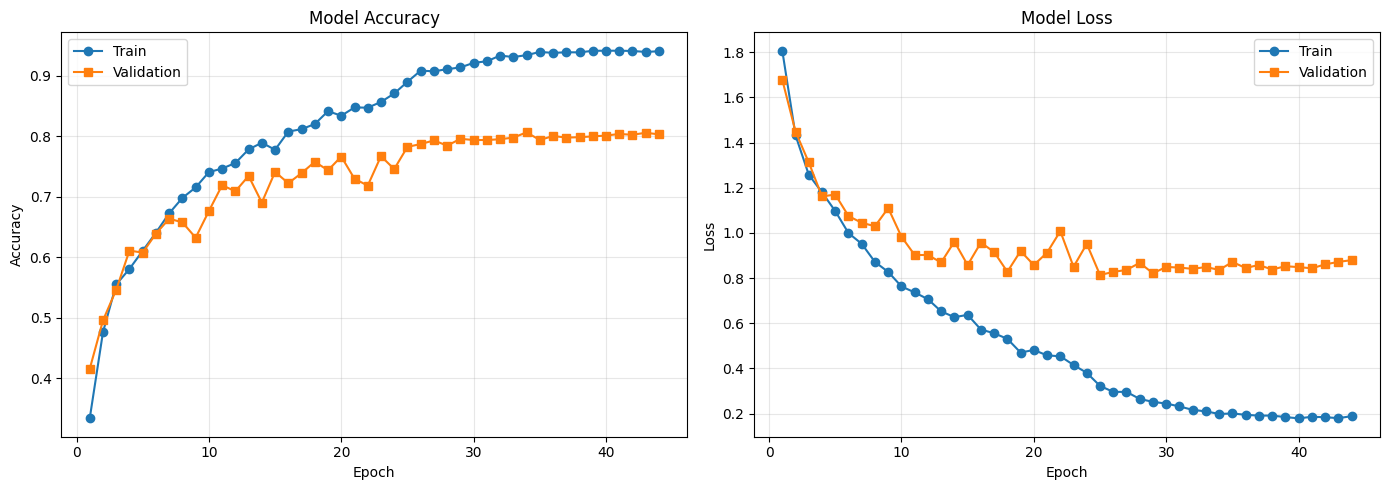

In [5]:
import matplotlib.pyplot as plt

# Plot training history
save_path = results_dir / 'figures' / 'training_history.png'
trainer.plot_training_history(save_path=save_path)

The training curves show:
- **Accuracy**: How well the model classifies genres over epochs
- **Loss**: Cross-entropy loss decrease over time
- **Overfitting check**: Gap between train and validation curves

If validation accuracy plateaus or decreases while training accuracy increases, the model is overfitting.

## 6. Evaluate on Test Set

Load the best model (based on validation accuracy) and evaluate on the held-out test set.

In [6]:
# Load best model
best_model_path = results_dir / 'models' / 'genre_cnn_pytorch_best.pth'
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from {best_model_path}")

# Evaluate
test_results = trainer.evaluate(X_test, y_test, batch_size=32)

print(f"\nTest Results:")
print(f"  Loss: {test_results['test_loss']:.4f}")
print(f"  Accuracy: {test_results['test_accuracy']:.4f}")
print(f"  Samples: {test_results['num_samples']}")

Loaded best model from c:\Programming\xai-music-genre-robustness\results\models\genre_cnn_pytorch_best.pth

Evaluating on test set...


Testing: 100%|██████████| 47/47 [00:00<00:00, 71.00it/s]

Test Loss: 0.7553
Test Accuracy: 0.7847

Test Results:
  Loss: 0.7553
  Accuracy: 0.7847
  Samples: 1500


## 7. Save Training Metrics

Save all training metrics and results to JSON for future reference.

In [7]:
# Combine all results
final_results = {
    'model_name': 'GenreClassifierCNN',
    'framework': 'PyTorch',
    'dataset': 'GTZAN',
    'num_classes': num_classes,
    'total_parameters': total_params,
    'trainable_parameters': trainable_params,
    'training_config': {
        'epochs': 50,
        'batch_size': 64,
        'learning_rate': 0.0005,
        'optimizer': 'Adam',
        'loss': 'CrossEntropyLoss',
        'early_stopping_patience': 10,
        'lr_scheduler': 'ReduceLROnPlateau',
        'weight_decay': 1e-4,
    },
    'test_loss': test_results['test_loss'],
    'test_accuracy': test_results['test_accuracy'],
    'num_test_samples': test_results['num_samples']
}

# Save metrics
trainer.save_training_metrics(final_results, filename='training_metrics.json')

print("\nTraining complete! ✓")
print(f"Best model saved to: {best_model_path}")
print(f"Metrics saved to: {results_dir / 'metrics' / 'training_metrics.json'}")
print(f"Training plot saved to: {results_dir / 'figures' / 'training_history.png'}")

Metrics saved to c:\Programming\xai-music-genre-robustness\results\metrics\training_metrics.json

Training complete! ✓
Best model saved to: c:\Programming\xai-music-genre-robustness\results\models\genre_cnn_pytorch_best.pth
Metrics saved to: c:\Programming\xai-music-genre-robustness\results\metrics\training_metrics.json
Training plot saved to: c:\Programming\xai-music-genre-robustness\results\figures\training_history.png


## Summary

**Training Results:**
- **Validation Accuracy**: 80.6% (best at epoch 34)
- **Test Accuracy**: 78.5%
- **Test Loss**: 0.76

**Model Architecture:**
- 4-block CNN: 32 → 64 → 128 → 256 filters
- Dropout: 0.15 (conv), 0.4 (FC)
- Total parameters: ~1.4M

**Training Configuration:**
- Optimizer: Adam (lr=0.0005, weight_decay=1e-4)
- Batch size: 64
- Epochs: 50 (with early stopping)

**Conclusion:**
The model achieves solid performance on GTZAN genre classification.

**Next Steps:**
- Adversarial attack generation (Notebook 04)
- Grad-CAM visualization (Notebook 05)